In [37]:
import gzip, pickle, os
from pathlib import Path
import numpy as np
from nilearn import plotting, datasets
from nilearn.maskers import NiftiLabelsMasker
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_and_label_atlas(path):
    atlas_data = datasets.fetch_atlas_schaefer_2018(n_rois=1000)
    atlas_data.labels = np.insert(atlas_data.labels, 0, "7Networks_NA_Background_0")
    schaefer_labels = np.array([b.decode('utf-8').split('_')[2] for b in atlas_data.labels])
    atlas_masker = NiftiLabelsMasker(labels_img=path, labels=list(schaefer_labels))
    atlas_masker.fit()
    return atlas_masker

def voxelwise_pearsonr(fmri_val, fmri_val_pred):
    ### Correlate recorded and predicted fMRI responses ###
    encoding_accuracy = np.zeros((fmri_val.shape[1]), dtype=np.float32)
    for p in range(len(encoding_accuracy)):
        encoding_accuracy[p] = pearsonr(fmri_val[:, p],
            fmri_val_pred[:, p])[0]
    return encoding_accuracy

In [19]:
# ─────────────────────────────────────────────────────────────
# Load saved fMRI predictions / ground-truth from a checkpoint
# ─────────────────────────────────────────────────────────────

# 1) Point to the run’s checkpoint directory
ckpt_dir = Path("checkpoints/r1c11do2")

# 2) Un-pickle the gzipped file
pred_file = ckpt_dir / "val_predictions.pkl.gz"
with gzip.open(pred_file, "rb") as f:
    pred_bundle = pickle.load(f)

# 3) Examine what you got
subj_ids      = ["sub-01", "sub-02", "sub-03", "sub-05"]
fmri_true     = pred_bundle["fmri_true"]     # list[np.ndarray], shape (T, V)
fmri_pred     = pred_bundle["fmri_pred"]     # list[np.ndarray], same shapes
atlas_maskers = [
    load_and_label_atlas(
        os.path.join('data', 'fmri', subject, 'atlas', f'{subject}_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz')
    )
    for subject in subj_ids
]
fmri_corr     = [voxelwise_pearsonr(true, pred) for true, pred in zip(fmri_true, fmri_pred)]

print(f"{len(subj_ids)} subjects loaded:")
for sid, y in zip(subj_ids, fmri_true):
    print(f"  sub-{sid}:  time points {y.shape[0]:>4},  voxels {y.shape[1]:>5}")

[get_dataset_dir] Dataset found in /u/danielcs/nilearn_data/schaefer_2018
[get_dataset_dir] Dataset found in /u/danielcs/nilearn_data/schaefer_2018
[get_dataset_dir] Dataset found in /u/danielcs/nilearn_data/schaefer_2018
[get_dataset_dir] Dataset found in /u/danielcs/nilearn_data/schaefer_2018
4 subjects loaded:
  sub-sub-01:  time points 23387,  voxels  1000
  sub-sub-02:  time points 23387,  voxels  1000
  sub-sub-03:  time points 22949,  voxels  1000
  sub-sub-05:  time points 23387,  voxels  1000


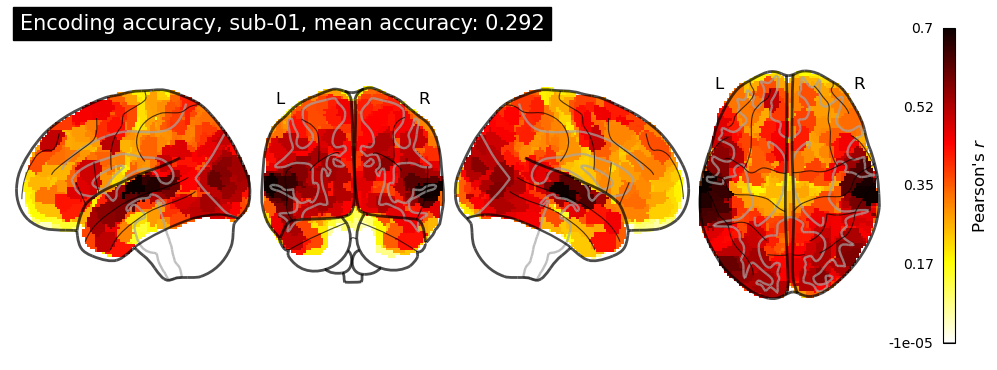

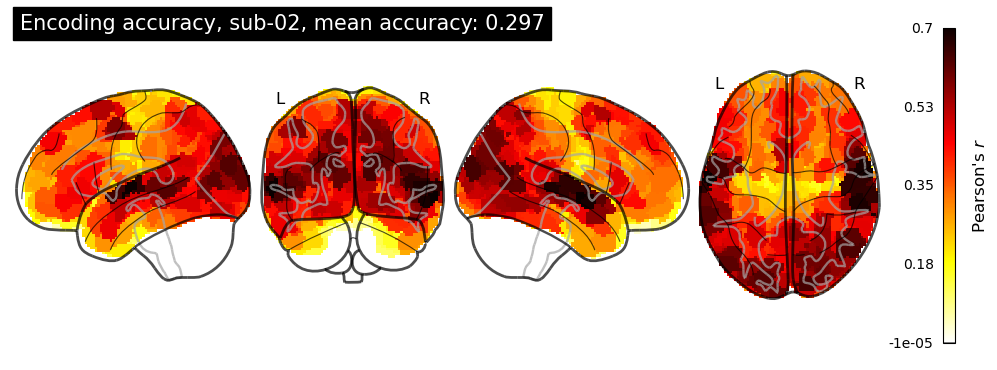

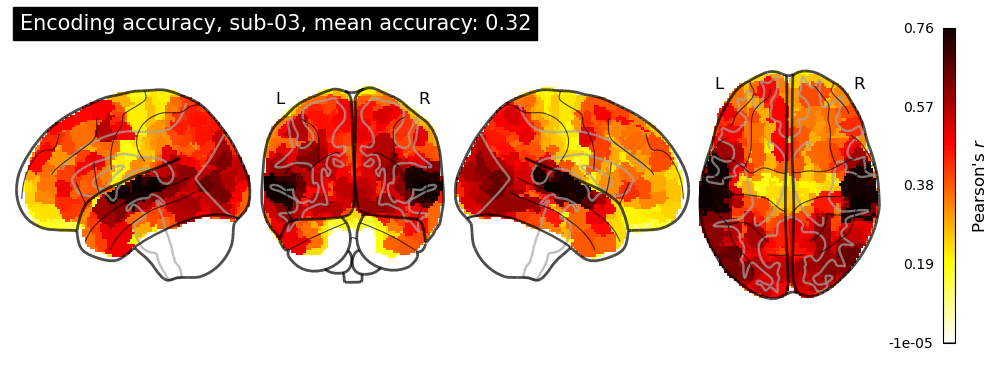

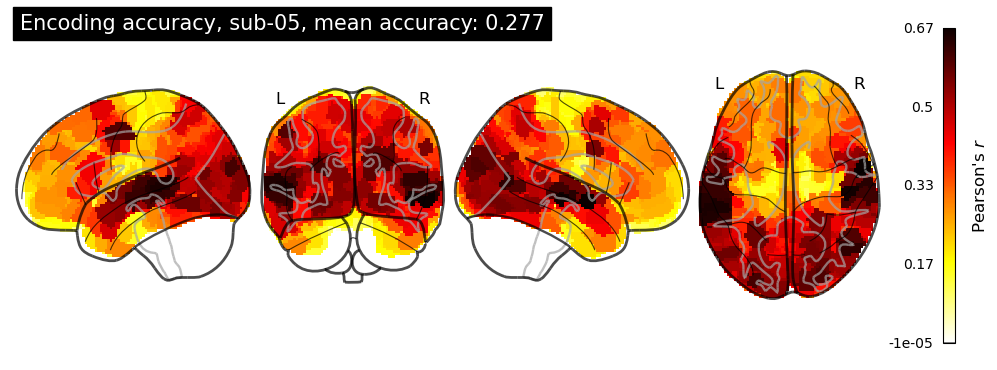

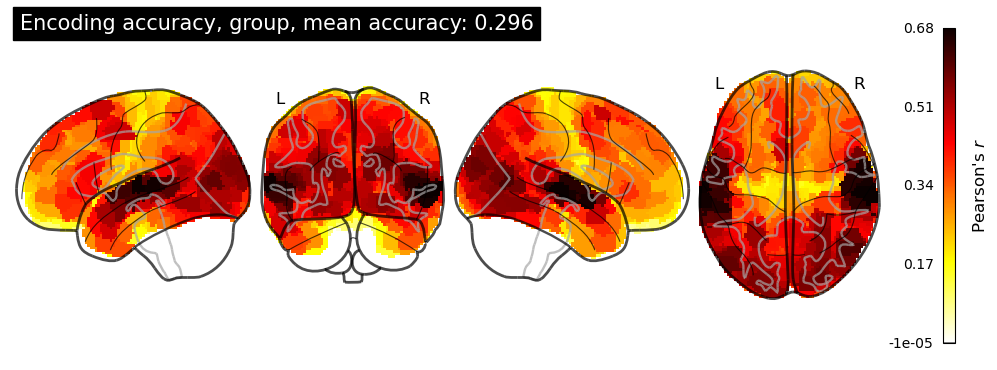

In [20]:
def plot_glass_brain(r, subj_id, masker):

    mean_r = np.round(np.mean(r), 3)

    ### Map the prediction accuracy onto a 3D brain atlas for plotting ###

    r_nii = masker.inverse_transform(r)

    ### Plot the encoding accuracy ###
    title = f"Encoding accuracy, {subj_id}, mean accuracy: " + str(mean_r)
    display = plotting.plot_glass_brain(
        r_nii,
        display_mode="lyrz",
        cmap='hot_r',
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=False,
        title=title
    )
    colorbar = display._cbar
    colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)
    plotting.show()

for i in range(len(subj_ids)):
    plot_glass_brain(fmri_corr[i], subj_ids[i], atlas_maskers[i])
plot_glass_brain(np.array(fmri_corr).mean(axis=0), "group", atlas_maskers[0])

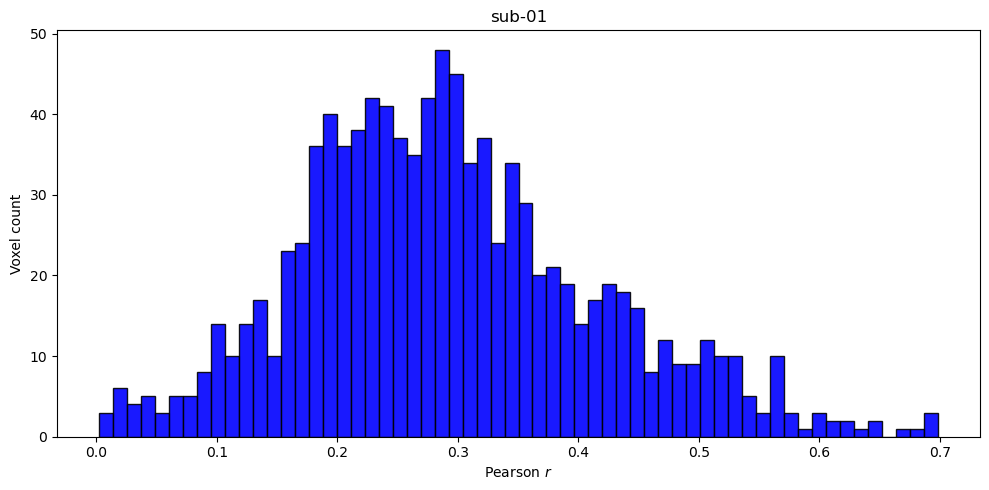

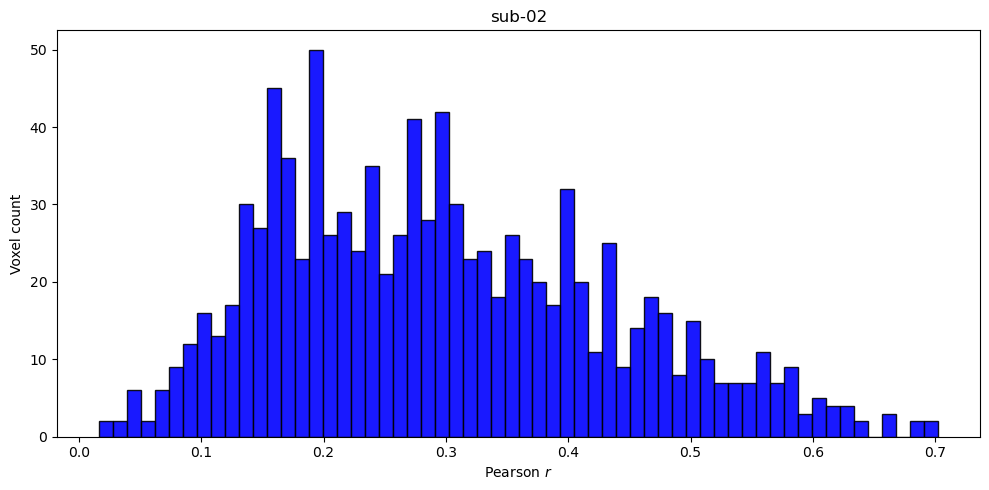

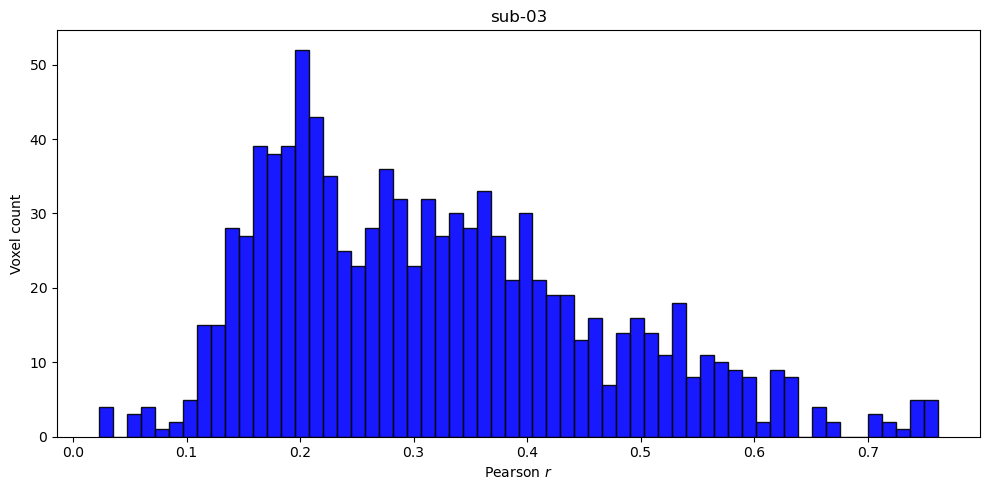

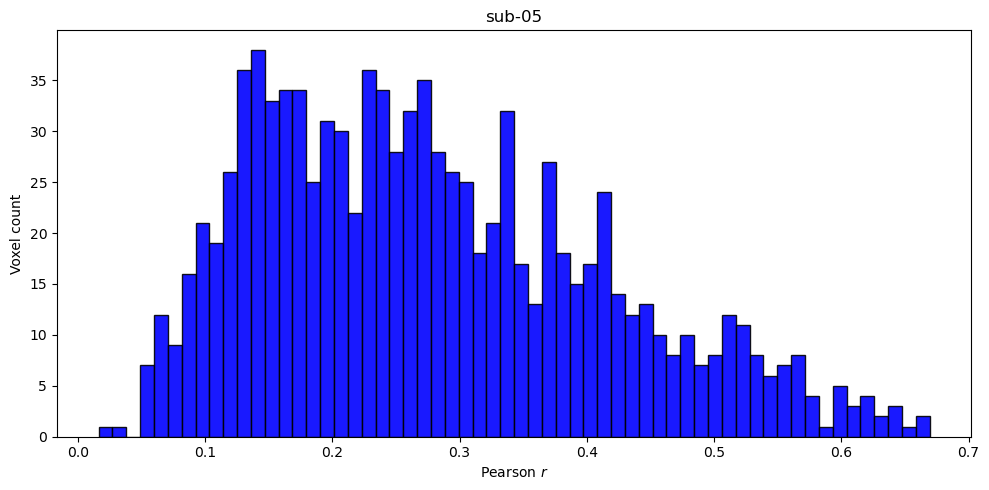

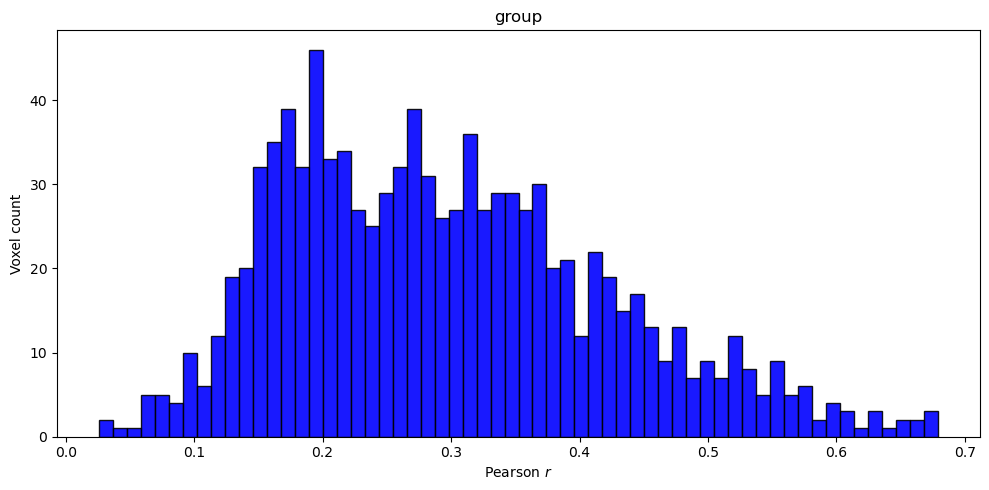

In [21]:
def plot_corr_hist(r, subj_id):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(r, bins=60, edgecolor="k", alpha=0.9, color='blue')
    ax.set_xlabel("Pearson $r$")
    ax.set_ylabel("Voxel count")
    ax.set_title(subj_id)
    fig.tight_layout()
    plt.show()
    
for i in range(len(subj_ids)):
    plot_corr_hist(fmri_corr[i], subj_ids[i])
plot_corr_hist(np.array(fmri_corr).mean(axis=0), "group")

In [22]:
def roi_table(r, subj_id, masker):
    labels_array = np.array(masker.labels[1:])
    roi_masks = {name: np.where(labels_array == name)[0] for name in np.unique(labels_array)}
    
    print(subj_id)
    for name, idxs in roi_masks.items():
        print(f'{name + ":":<12s} {f"{np.mean(r[idxs]):.3f}":<30s}')
        
for i in range(len(subj_ids)):
    roi_table(fmri_corr[i], subj_ids[i], atlas_maskers[i])
roi_table(np.array(fmri_corr).mean(axis=0), "group", atlas_maskers[i])  

sub-01
Cont:        0.252                         
Default:     0.305                         
DorsAttn:    0.333                         
Limbic:      0.123                         
SalVentAttn: 0.263                         
SomMot:      0.267                         
Vis:         0.391                         
sub-02
Cont:        0.290                         
Default:     0.317                         
DorsAttn:    0.344                         
Limbic:      0.120                         
SalVentAttn: 0.249                         
SomMot:      0.237                         
Vis:         0.413                         
sub-03
Cont:        0.291                         
Default:     0.340                         
DorsAttn:    0.358                         
Limbic:      0.174                         
SalVentAttn: 0.263                         
SomMot:      0.266                         
Vis:         0.447                         
sub-05
Cont:        0.266                         
Defa

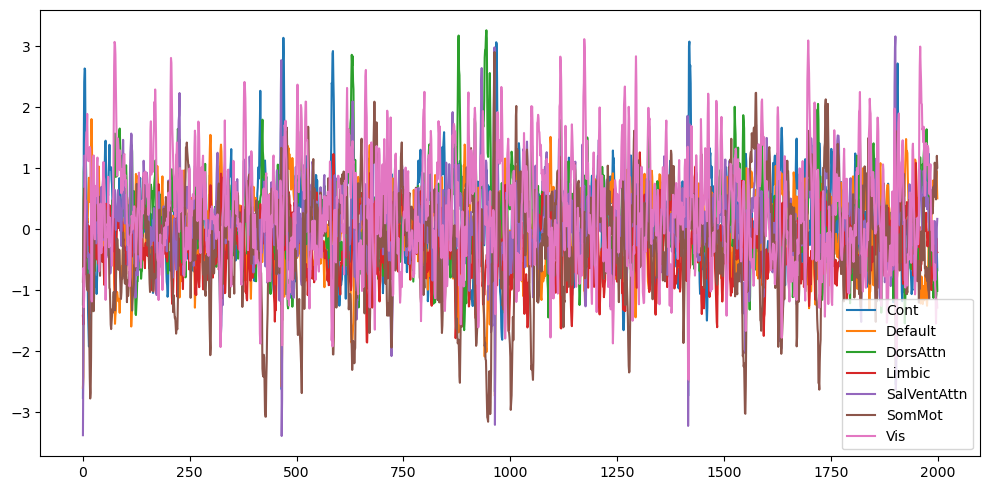

In [23]:
def plot_roi_timecourses(fmri_pred, fmri_true, subj_id, masker):
    labels_array = np.array(masker.labels[1:])
    roi_masks = {name: np.where(labels_array == name)[0] for name in np.unique(labels_array)}
    
    fig, ax = plt.subplots(figsize=(10, 5))
    for name, idxs in roi_masks.items():
        ax.plot(fmri_pred[:2000, idxs].mean(axis=1) - fmri_true[:2000, idxs].mean(axis=1), label=name)
        
    ax.legend()
    fig.tight_layout()
    plt.show()

i = 1
plot_roi_timecourses(fmri_pred[i], fmri_true[i], subj_ids[i], atlas_maskers[i])

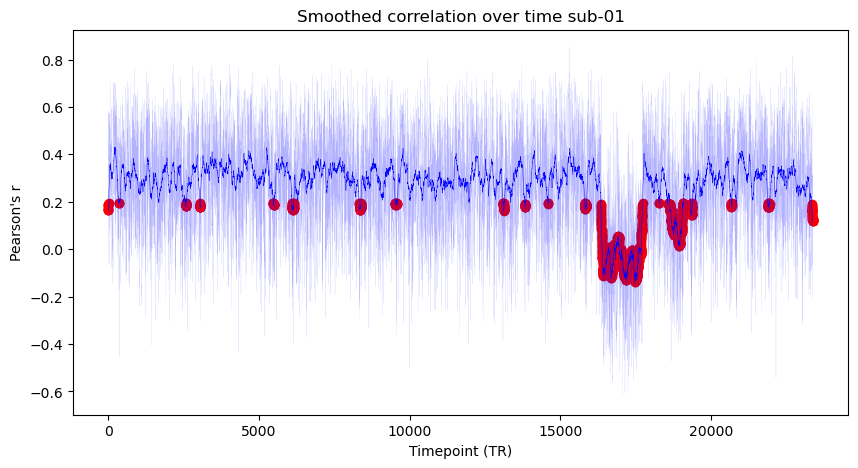

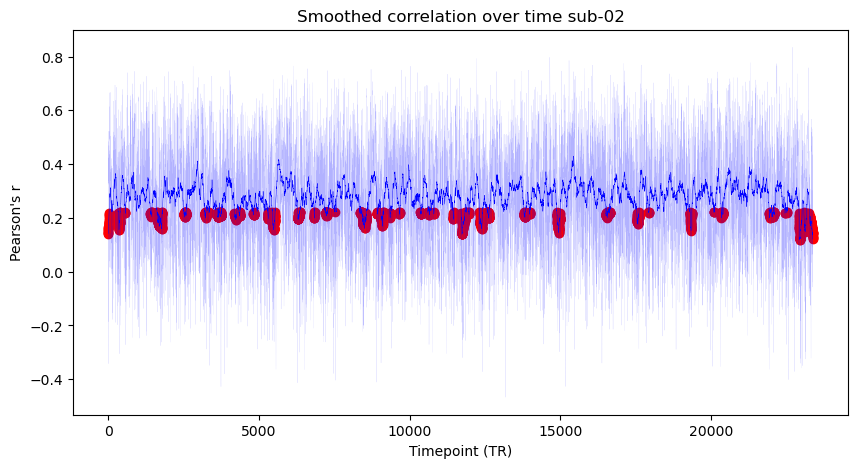

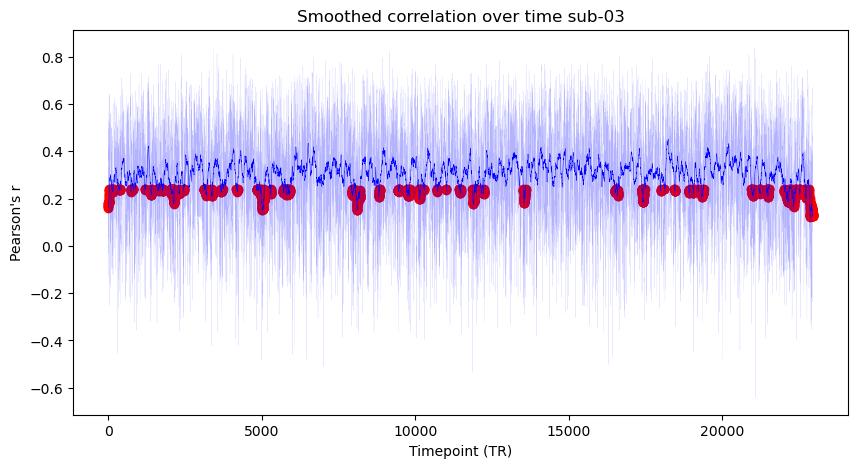

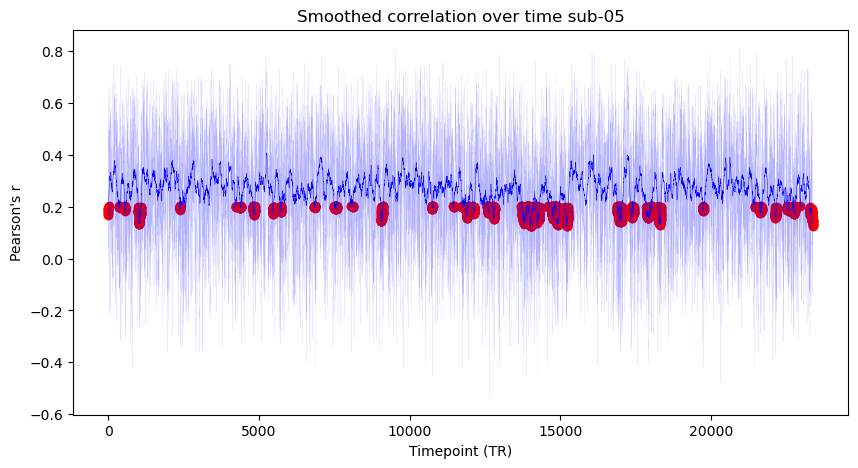

In [24]:
def plot_time_corr(fmri_pred, fmri_true, subj_id):
    r_t = np.array([pearsonr(fmri_pred[t], fmri_true[t])[0] for t in range(fmri_true.shape[0])])
    
    window = 100
    smoothed = np.convolve(r_t, np.ones(window)/window, mode="same")
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(r_t, lw=0.1, linestyle="-", color="b", alpha=0.3)
    ax.plot(smoothed, color="b", lw=0.3)
    ax.set_ylabel("Pearson's r")
    ax.set_xlabel("Timepoint (TR)")
    ax.set_title(f"Smoothed correlation over time {subj_id}")
    ax.vlines(np.where(np.isnan(r_t))[0], ymin=np.nanmin(r_t), ymax=np.nanmax(r_t), color='r', lw=0.1)
    fig.show()

    k = max(1, int(0.1 * len(r_t)))
    worst_idx = np.argsort(smoothed)[:k]
    
    
    ax.scatter(worst_idx, smoothed[worst_idx], color="red", label="worst 5 %")
    
for i in range(4):
    plot_time_corr(fmri_pred[i], fmri_true[i], subj_ids[i])

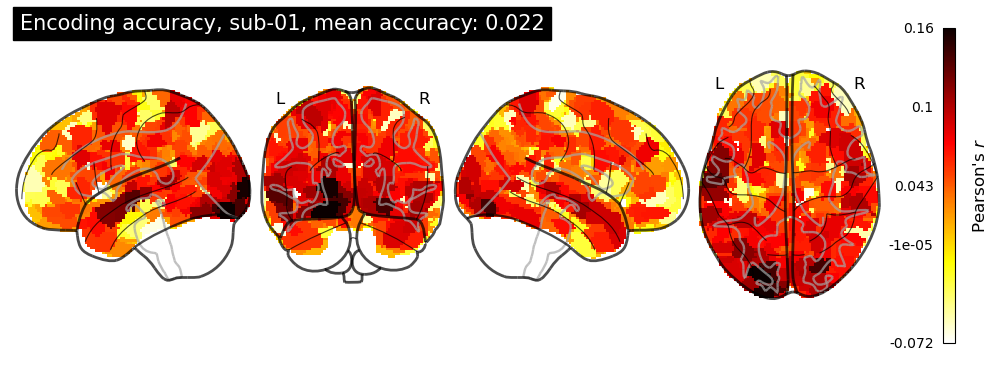

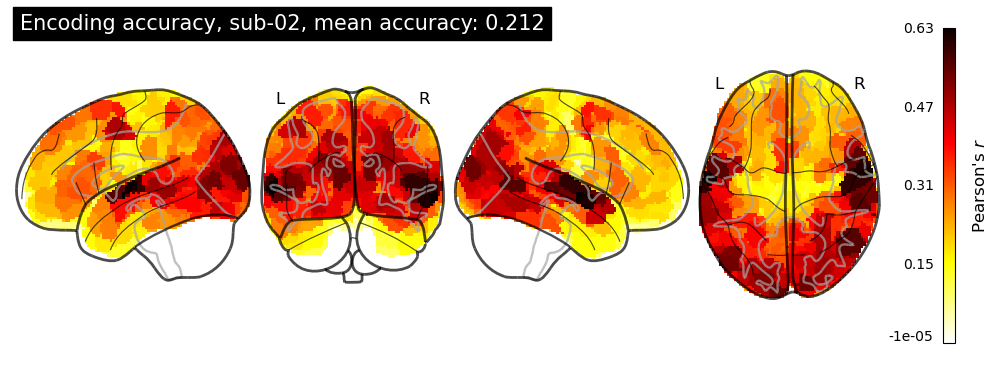

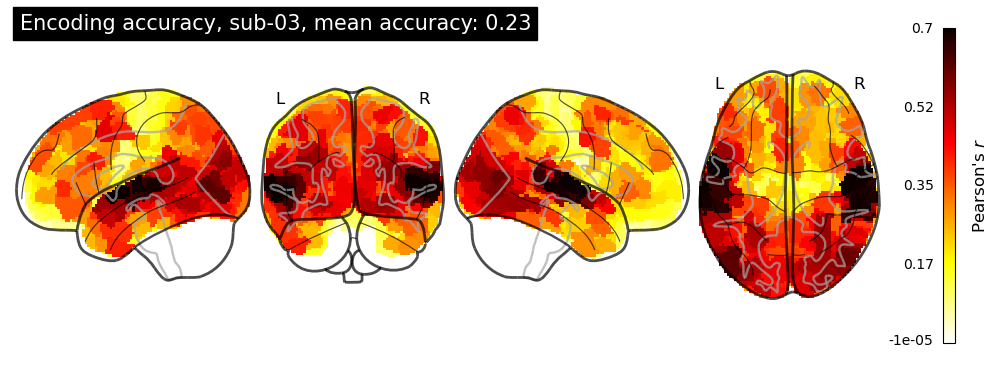

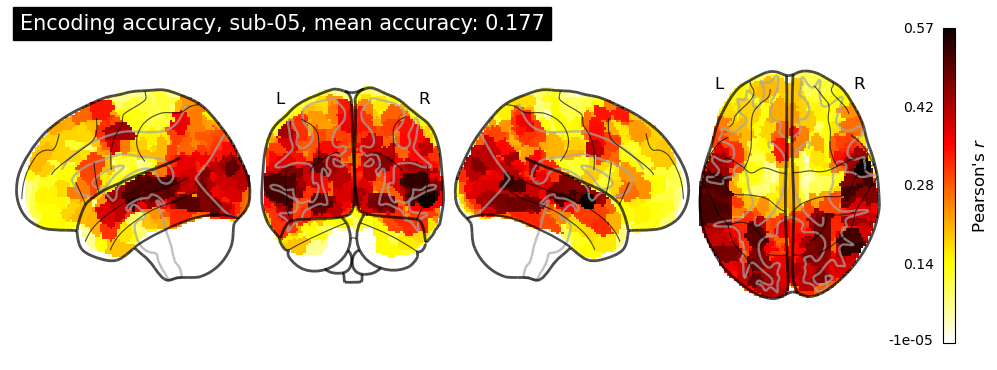

In [25]:
def plot_glass_bads(fmri_pred, fmri_true, subj_id, masker, pct_bads=.1):
    r_t = np.array([pearsonr(fmri_pred[t], fmri_true[t])[0] for t in range(fmri_true.shape[0])])
    
    window = 100
    smoothed = np.convolve(r_t, np.ones(window)/window, mode="same")
    
    k = max(1, int(pct_bads * len(r_t)))
    worst_idx = np.argsort(smoothed)[:k]
    
    r = voxelwise_pearsonr(fmri_pred[worst_idx], fmri_true[worst_idx])
    
    plot_glass_brain(r, subj_id, masker)
    
for i in range(4):
    plot_glass_bads(fmri_pred[i], fmri_true[i], subj_ids[i], atlas_maskers[i])

In [26]:
def roi_table(r, subj_id, masker, out_dir="plots"):
    """
    Save a CSV of mean voxel-wise r per Schaefer ROI and return the DataFrame.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    labels_array = np.array(masker.labels[1:])           # skip background
    roi_masks = {name: np.where(labels_array == name)[0]
                 for name in np.unique(labels_array)}

    rows = [{"label": name, "mean_r": np.mean(r[idxs])}
            for name, idxs in roi_masks.items()]
    df = pd.DataFrame(rows)
    df = df.set_index("label").sort_values("mean_r", ascending=False)
    #csv_file = out_dir / f"{subj_id}_roi_table.csv"
    #df.to_csv(csv_file, index=False)
    return df

In [27]:
roi_table(fmri_corr[0], "", atlas_maskers[0])

,mean_r
label,
Vis,0.391360
DorsAttn,0.333172
Default,0.304527
SomMot,0.267341
SalVentAttn,0.262909
Cont,0.252178
Limbic,0.123105


In [52]:
def plot_mean_voxelwise_xcorr(fmri_true: np.ndarray, 
                              fmri_pred: np.ndarray, 
                              subj_id: str,
                              max_lag: int = 20):
    """
    Plots the mean voxelwise cross-correlation between true and predicted BOLD signals.
    
    Args:
      fmri_true:  array of shape (T, V) – true BOLD time-series (T timepoints, V voxels)
      fmri_pred:  array of shape (T, V) – predicted BOLD time-series (same shape)
      max_lag:    maximum lag (in samples/TRs) to include on either side of zero
    
    Returns:
      lags:      array of lag values
      mean_corr: array of mean correlation at each lag
    """
    T, V = fmri_true.shape
    if fmri_pred.shape != (T, V):
        raise ValueError("`fmri_true` and `fmri_pred` must have the same shape (T, V)")
    
    # z-score each voxel time-course
    t0 = (fmri_true - fmri_true.mean(axis=0)) / fmri_true.std(axis=0, ddof=0)
    p0 = (fmri_pred - fmri_pred.mean(axis=0)) / fmri_pred.std(axis=0, ddof=0)
    
    # FFT-based full cross-correlation for all voxels simultaneously
    n = 2 * T - 1
    fft_t = np.fft.fft(t0, n=n, axis=0)
    fft_p = np.fft.fft(p0, n=n, axis=0)
    corr_full = np.fft.ifft(fft_t * np.conj(fft_p), axis=0).real / T  # (2T-1, V)
    
    # Extract central window for lags [-max_lag, +max_lag]
    center = T - 1
    lags = np.arange(-max_lag, max_lag + 1)
    corr_window = corr_full[center - max_lag : center + max_lag + 1, :]
    
    # Plot
    plt.figure(figsize=(6, 4))
    
    # Mean correlation across voxels
    mean_corr = np.nanmean(corr_window, axis=1)
    plt.plot(lags, mean_corr)
        
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel("Lag (TR)")
    plt.ylabel("Mean voxelwise correlation")
    plt.title(f"Mean voxelwise cross-correlation ({subj_id})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return lags, mean_corr

def plot_roi_voxelwise_xcorr(fmri_true: np.ndarray, 
                              fmri_pred: np.ndarray, 
                              subj_id: str,
                              masker: NiftiLabelsMasker,
                              max_lag: int = 20):
    """
    Plots the mean voxelwise cross-correlation between true and predicted BOLD signals.
    
    Args:
      fmri_true:  array of shape (T, V) – true BOLD time-series (T timepoints, V voxels)
      fmri_pred:  array of shape (T, V) – predicted BOLD time-series (same shape)
      max_lag:    maximum lag (in samples/TRs) to include on either side of zero
    
    Returns:
      lags:      array of lag values
      mean_corr: array of mean correlation at each lag
    """
    T, V = fmri_true.shape
    if fmri_pred.shape != (T, V):
        raise ValueError("`fmri_true` and `fmri_pred` must have the same shape (T, V)")
    
    # z-score each voxel time-course
    t0 = (fmri_true - fmri_true.mean(axis=0)) / fmri_true.std(axis=0, ddof=0)
    p0 = (fmri_pred - fmri_pred.mean(axis=0)) / fmri_pred.std(axis=0, ddof=0)
    
    # FFT-based full cross-correlation for all voxels simultaneously
    n = 2 * T - 1
    fft_t = np.fft.fft(t0, n=n, axis=0)
    fft_p = np.fft.fft(p0, n=n, axis=0)
    corr_full = np.fft.ifft(fft_t * np.conj(fft_p), axis=0).real / T  # (2T-1, V)
    
    # Extract central window for lags [-max_lag, +max_lag]
    center = T - 1
    lags = np.arange(-max_lag, max_lag + 1)
    corr_window = corr_full[center - max_lag : center + max_lag + 1, :]
        
    labels_array = np.array(masker.labels[1:])           # skip background
    roi_masks = {name: np.where(labels_array == name)[0]
                 for name in np.unique(labels_array)}
    
    roi_corr = {name: np.nanmean(corr_window[:, mask]) for name, mask in roi_masks.items()}
    
    # Plot
    plt.figure(figsize=(6, 4))

    for name, mean_corr in roi_corr.items():
        plt.plot(lags, mean_corr, label=name)
        
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel("Lag (TR)")
    plt.ylabel("Mean voxelwise correlation")
    plt.title(f"Mean voxelwise cross-correlation ({subj_id})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return lags, mean_corr

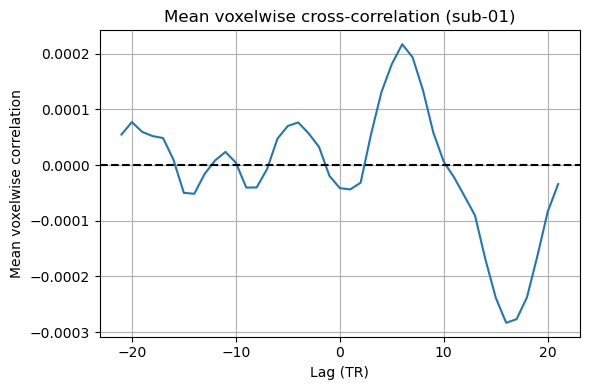

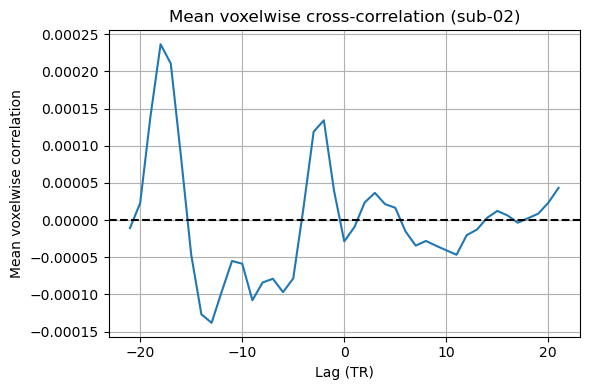

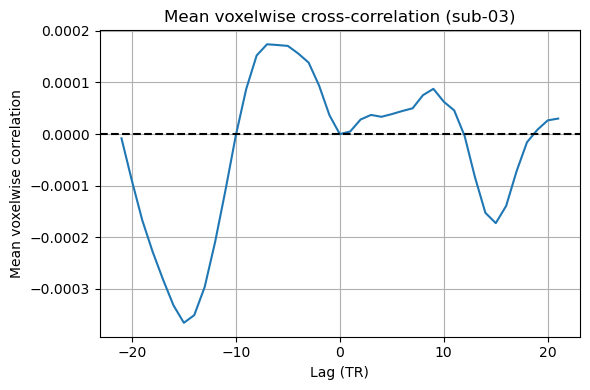

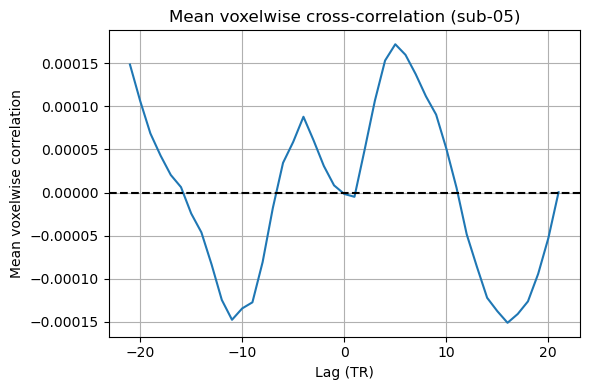

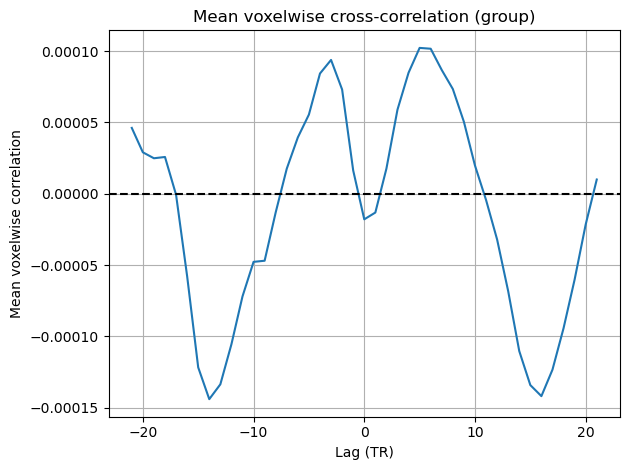

In [46]:
lagss = np.zeros((4, 43))
corrs = np.zeros((4, 43))
mean_corrss = []
for i in range(4):
    lagss[i], corrs[i] = plot_mean_voxelwise_xcorr(fmri_true[i], fmri_pred[i], subj_ids[i], 21)
plt.plot(lagss.mean(axis=0), corrs.mean(axis=0))
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Lag (TR)")
plt.ylabel("Mean voxelwise correlation")
plt.title(f"Mean voxelwise cross-correlation (group)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
r_vox = np.array([np.corrcoef(true[:,v], pred[:,v])[0,1] for v in range(V)])

In [70]:
print(r_vox.mean())        # likely ~0
print(r_vox[r_vox>0].mean())   # the “0.29” you quoted

0.29220050036166856
0.29220050036166856


ValueError: x and y must have same first dimension, but have shapes (43,) and (1,)

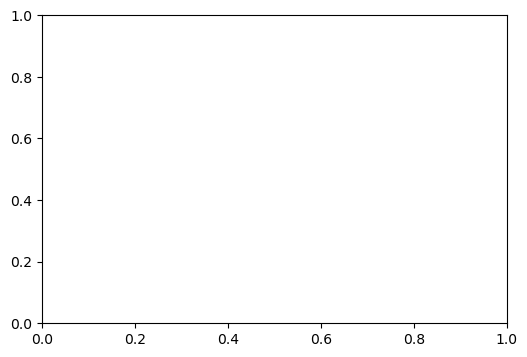

In [53]:
plot_roi_voxelwise_xcorr(fmri_true[i], fmri_pred[i], subj_ids[i], atlas_maskers[i], 21)

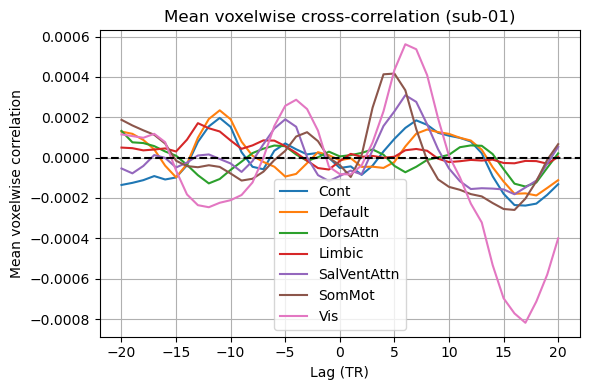

In [68]:
true, pred = fmri_true[0], fmri_pred[0]
max_lag = 20
masker = atlas_maskers[0]
subj_id = subj_ids[0]

T, V = true.shape
if pred.shape != (T, V):
    raise ValueError("`fmri_true` and `fmri_pred` must have the same shape (T, V)")

# z-score each voxel time-course
t0 = (true - true.mean(axis=0)) / true.std(axis=0, ddof=0)
p0 = (pred - pred.mean(axis=0)) / pred.std(axis=0, ddof=0)

# FFT-based full cross-correlation for all voxels simultaneously
n = 2 * T - 1
fft_t = np.fft.fft(t0, n=n, axis=0)
fft_p = np.fft.fft(p0, n=n, axis=0)
corr_full = np.fft.ifft(fft_t * np.conj(fft_p), axis=0).real / T  # (2T-1, V)

# Extract central window for lags [-max_lag, +max_lag]
center = T - 1
lags = np.arange(-max_lag, max_lag + 1)
corr_window = corr_full[center - max_lag : center + max_lag + 1, :]

labels_array = np.array(masker.labels[1:])           # skip background
roi_masks = {name: np.where(labels_array == name)[0]
             for name in np.unique(labels_array)}

roi_corr = {name: np.nanmean(corr_window[:, mask], axis=1) for name, mask in roi_masks.items()}

# Plot
plt.figure(figsize=(6, 4))

for name, mean_corr in roi_corr.items():
    plt.plot(lags, mean_corr, label=name)

plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Lag (TR)")
plt.ylabel("Mean voxelwise correlation")
plt.legend()
plt.title(f"Mean voxelwise cross-correlation ({subj_id})")
plt.grid(True)
plt.tight_layout()
plt.show()

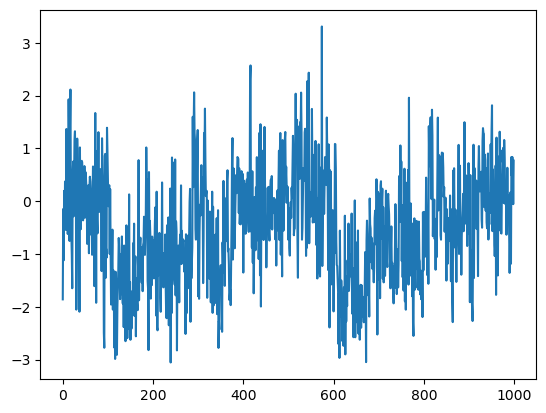

In [73]:
plt.plot(t0[0])

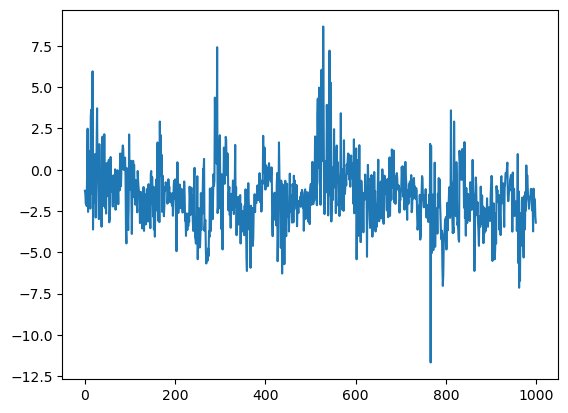

In [74]:
plt.plot(p0[0])

In [131]:
from scipy.signal import correlate, correlation_lags

true = fmri_true[0]
pred = fmri_pred[0]

T, V = true.shape
max_lag = 20

t0 = (true - true.mean(axis=0)) / true.std(axis=0)
p0 = (pred - pred.mean(axis=0)) / pred.std(axis=0)

corr = np.array([correlate(t0[:, v], p0[:, v]) for v in range(V)]).T

center = T - 1
lags = np.arange(-max_lag, max_lag + 1)
corr = corr[center - max_lag : center + max_lag + 1] / T

In [132]:
corr.shape

(41, 1000)

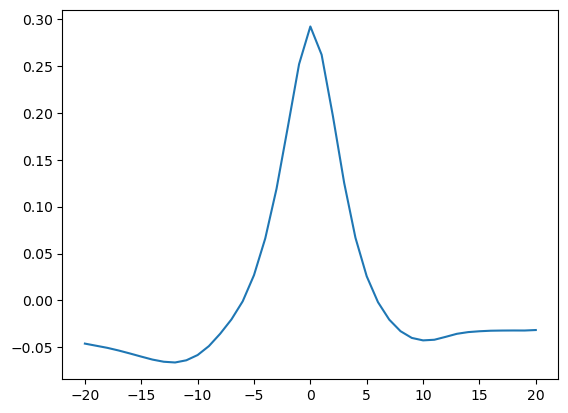

In [133]:
plt.plot(lags, corr.mean(axis=1))

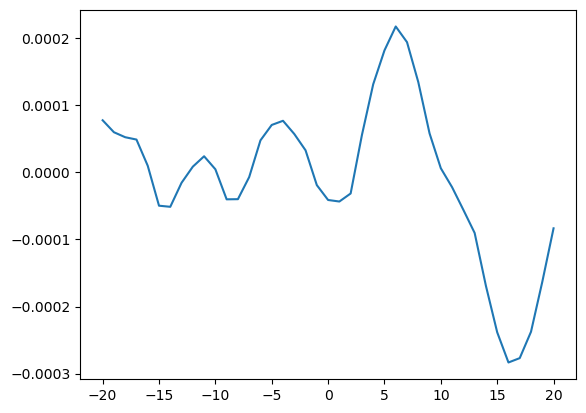

In [130]:
# 0 ── drop padded frames first (if you have attn_mask) -----------------------
# true = true[attn_mask];  pred = pred[attn_mask]  # shape (T’, V)

# 1 ── z-score, but guard against σ=0 -----------------------------------------
std_t = true.std(axis=0, ddof=0)
std_p = pred.std(axis=0, ddof=0)
keep  = (std_t > 0) & (std_p > 0)              # mask non-flat voxels
t0 = (true[:, keep] - true[:, keep].mean(0)) / std_t[keep]
p0 = (pred[:, keep] - pred[:, keep].mean(0)) / std_p[keep]

# 2 ── FFT cross-corr ---------------------------------------------------------
T = t0.shape[0]
n = 2*T - 1
ff = np.fft.fft(t0, n=n, axis=0) * np.conj(np.fft.fft(p0, n=n, axis=0))
corr_full = np.fft.ifft(ff, axis=0).real                                     # (2T-1,V’)

# 3 ── unbiased normalisation: divide each lag row by (T-|τ|) ----------------
lags = np.arange(-max_lag, max_lag+1)
center = T - 1
norm   = T - np.abs(lags)                                                    # (2L+1,)
corr_window = corr_full[center-max_lag:center+max_lag+1] / norm[:, None]

# 4 ── average over voxels & plot --------------------------------------------
mean_corr = np.nanmean(corr_window, axis=1)
plt.plot(lags, mean_corr)